# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [41]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/OneDrive/ITA/Mestrado/2021_TE-282 - Meta heurísticas/P-MetaHeuristica/p_metaheuristic/data/log


In [42]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [43]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [44]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [45]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [46]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        # df = df[df.Q>1]
        df.loc[df[-1:].index, 'last_iter'] = 1
    except:
        print(filename)

    return df

# ray.init(num_cpus=16)

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


(import_logs pid=55637) 
(import_logs pid=56192) 
(import_logs pid=56202) 
(import_logs pid=56210) 
(import_logs pid=55637) 
(import_logs pid=56206) 
(import_logs pid=56209) 


In [47]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(1069975, 18)
(1061, 18)


In [48]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069975 entries, 0 to 1069974
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   iter          1069975 non-null  int64  
 1   cost          1069975 non-null  float64
 2   risk          1069975 non-null  float64
 3   return        1069975 non-null  float64
 4   X             1069975 non-null  object 
 5   Z             1069975 non-null  object 
 6   Q             1069975 non-null  float64
 7   max_iter      1069975 non-null  int64  
 8   pop_size      1069975 non-null  int64  
 9   mem_consider  1069975 non-null  float64
 10  pitch_adj     1069975 non-null  float64
 11  alpha         1069975 non-null  float64
 12  lambda        1069975 non-null  float64
 13  port_n        1069975 non-null  int64  
 14  k             1069975 non-null  int64  
 15  seed          0 non-null        float64
 16  filename      1069975 non-null  object 
 17  last_iter     1061 non-null

## Portfólios

### Geral

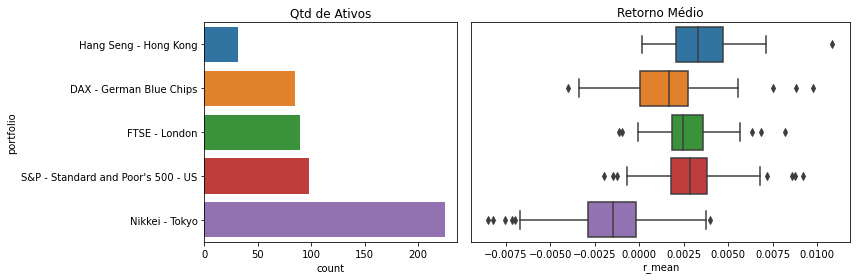

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [50]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [51]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

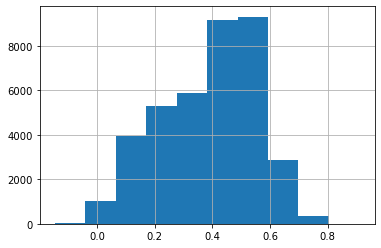

In [52]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

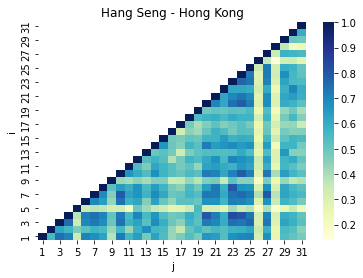

In [53]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [54]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


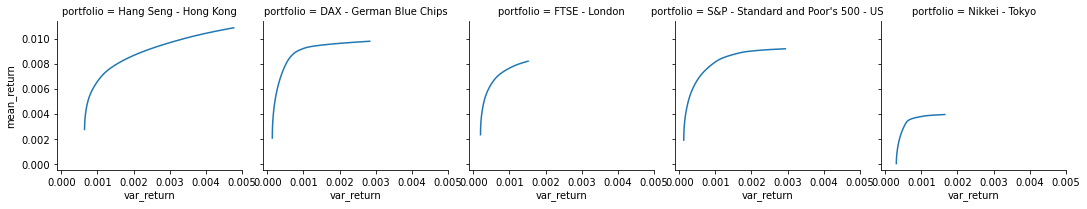

In [55]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

In [56]:
col_order = ['iDR', 'idID', 'TID', 'Random']
row_order = ['Best', 'First', 'Random']

In [57]:
all_data.drop(['X', 'Z'], axis=1).head()

,iter,cost,risk,return,Q,max_iter,pop_size,mem_consider,pitch_adj,alpha,lambda,port_n,k,seed,filename,last_iter
0,0,-0.006935,0.086537,0.007442,5.0,1000,1000,0.5,0.5,0.1,0.0054,1,5,NaN,log_gls_20211210_221138_408527.csv,NaN
1,1,-0.006935,0.086537,0.007442,5.0,1000,1000,0.5,0.5,0.1,0.0054,1,5,NaN,log_gls_20211210_221138_408527.csv,NaN
2,2,-0.006935,0.086537,0.007442,5.0,1000,1000,0.5,0.5,0.1,0.0054,1,5,NaN,log_gls_20211210_221138_408527.csv,NaN
3,3,-0.006935,0.086537,0.007442,5.0,1000,1000,0.5,0.5,0.1,0.0054,1,5,NaN,log_gls_20211210_221138_408527.csv,NaN
4,4,-0.006935,0.086537,0.007442,5.0,1000,1000,0.5,0.5,0.1,0.0054,1,5,NaN,log_gls_20211210_221138_408527.csv,NaN


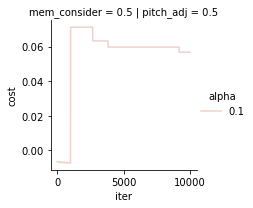

In [58]:
data = all_data.copy()
sns.relplot(data=data, x='iter', y='cost', hue='alpha', row='mem_consider', col='pitch_adj',
            kind='line', height=3)

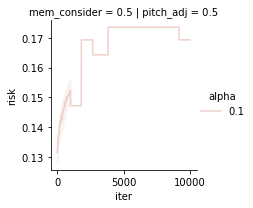

In [59]:
data = all_data.copy()
sns.relplot(data=data, x='iter', y='risk', hue='alpha', row='mem_consider', col='pitch_adj',
            kind='line', height=3)

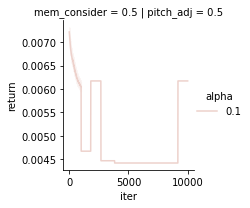

In [60]:
data = all_data.copy()
sns.relplot(data=data, x='iter', y='return', hue='alpha', row='mem_consider', col='pitch_adj',
            kind='line', height=3)

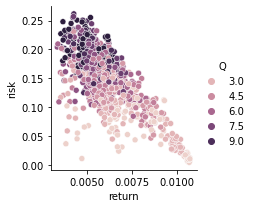

In [62]:
sns.relplot(data=best_data, x='return', y='risk', kind='scatter',
            height=3, hue='Q')


In [63]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,1061.0,1007.459001,2.763043e+02,974.000000,999.000000,999.000000,999.000000,9999.000000
cost,1061.0,-0.007087,2.716907e-03,-0.010749,-0.008581,-0.006705,-0.005672,0.056817
risk,1061.0,0.152592,5.739882e-02,0.004545,0.115635,0.167388,0.195473,0.261668
return,1061.0,0.006051,1.643242e-03,0.003327,0.004946,0.005542,0.006621,0.010749
Q,1061.0,6.041470,2.601555e+00,2.000000,4.000000,6.000000,8.000000,10.000000
max_iter,1061.0,1008.482564,2.763025e+02,1000.000000,1000.000000,1000.000000,1000.000000,10000.000000
pop_size,1061.0,853.722903,3.472830e+02,30.000000,1000.000000,1000.000000,1000.000000,1000.000000
mem_consider,1061.0,0.500000,0.000000e+00,0.500000,0.500000,0.500000,0.500000,0.500000
pitch_adj,1061.0,0.500000,0.000000e+00,0.500000,0.500000,0.500000,0.500000,0.500000
alpha,1061.0,0.100000,1.388433e-17,0.100000,0.100000,0.100000,0.100000,0.100000


Text(0, 0.5, 'mean_return')

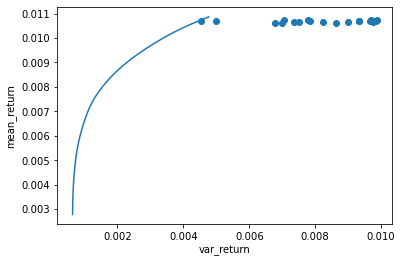

In [66]:
data = best_data[best_data['risk']<0.01]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.risk, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

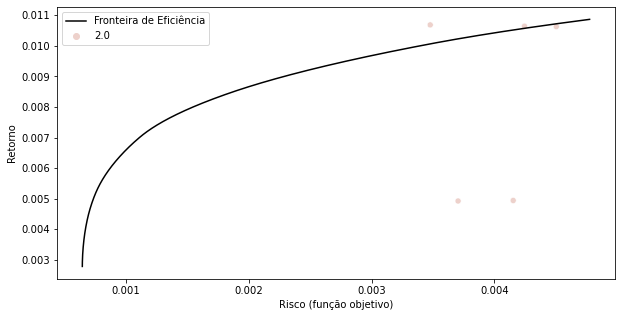

In [ ]:
data = best_data[best_data['obj']<0.005]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='obj', y='return', hue='Q')
plt.ylabel("Retorno")
plt.xlabel("Risco (função objetivo)")
plt.legend()

In [ ]:
best_data.drop(['X', 'Z'], axis=1).head()

,iter,obj,return,Q,max_iter,pop_size,mem_consider,pitch_adj,alpha,exp_return,port_n,k,seed,filename,last_iter
999,999,0.144704,0.004960,9.0,1000,30,0.5,0.5,0.1,0.0017,1,9,NaN,log_gls_20211210_201507_508349.csv,1.0
1999,999,0.063610,0.005625,4.0,1000,30,0.5,0.5,0.1,0.0013,1,4,NaN,log_gls_20211210_201500_510165.csv,1.0
2999,999,0.018475,0.001747,2.0,1000,29,0.5,0.5,0.1,0.0010,1,2,NaN,log_gls_20211210_201436_940165.csv,1.0
3999,999,0.141849,0.004070,9.0,1000,29,0.5,0.5,0.1,0.0023,1,9,NaN,log_gls_20211210_201440_521707.csv,1.0
4999,999,0.102455,0.005276,8.0,1000,30,0.5,0.5,0.1,0.0011,1,8,NaN,log_gls_20211210_201440_476306.csv,1.0


Text(0, 0.5, 'mean_return')

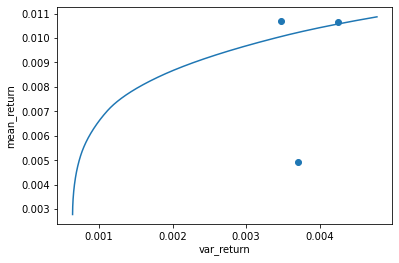

In [ ]:
data = best_data[best_data['obj']<0.005]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [ ]:
best_data.head()

,iter,obj,return,X,Z,Q,max_iter,pop_size,mem_consider,pitch_adj,alpha,exp_return,port_n,k,seed,filename,last_iter
999,999,0.144704,0.004960,[0. 0.09073014 0. 0. 0...,[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. ...,9.0,1000,30,0.5,0.5,0.1,0.0017,1,9,NaN,log_gls_20211210_201507_508349.csv,1.0
1999,999,0.063610,0.005625,[0. 0. 0. 0. 0...,[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. ...,4.0,1000,30,0.5,0.5,0.1,0.0013,1,4,NaN,log_gls_20211210_201500_510165.csv,1.0
2999,999,0.018475,0.001747,[0.02693715 0. 0. 0. 0...,[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,2.0,1000,29,0.5,0.5,0.1,0.0010,1,2,NaN,log_gls_20211210_201436_940165.csv,1.0
3999,999,0.141849,0.004070,[0. 0. 0. 0. 0...,[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. ...,9.0,1000,29,0.5,0.5,0.1,0.0023,1,9,NaN,log_gls_20211210_201440_521707.csv,1.0
4999,999,0.102455,0.005276,[0.03832522 0. 0. 0. 0...,[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,8.0,1000,30,0.5,0.5,0.1,0.0011,1,8,NaN,log_gls_20211210_201440_476306.csv,1.0


In [ ]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,240.0,969.954167,1.168630e+02,239.000000,999.000000,999.000000,999.000000,999.000000
obj,240.0,0.087490,4.749963e-02,0.003477,0.047271,0.095106,0.129544,0.167995
return,240.0,0.005404,2.018364e-03,0.001747,0.004259,0.004937,0.005906,0.010738
Q,240.0,5.816667,2.663823e+00,2.000000,3.000000,6.000000,8.000000,10.000000
max_iter,240.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
pop_size,240.0,18.295833,1.150259e+01,1.000000,5.000000,22.000000,30.000000,30.000000
mem_consider,240.0,0.500000,0.000000e+00,0.500000,0.500000,0.500000,0.500000,0.500000
pitch_adj,240.0,0.500000,0.000000e+00,0.500000,0.500000,0.500000,0.500000,0.500000
alpha,240.0,0.100000,1.390679e-17,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,240.0,0.002984,1.903099e-03,0.000100,0.001500,0.002800,0.004400,0.009800


In [ ]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(240, 18)


/var/folders/4s/j92phfsd2cn8533b6sx7q1440000gn/T/ipykernel_46070/3923848381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)


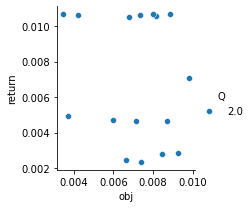

In [ ]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], hue='Q')
g.map(sns.scatterplot, 'obj', 'return')
g.add_legend()
g=g

Text(0, 0.5, 'mean_return')

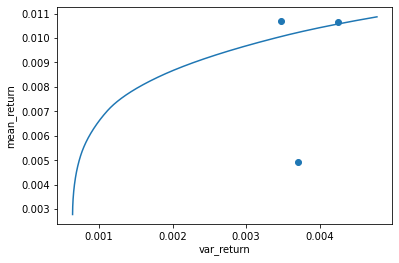

In [ ]:
port = 1
data = best_best_data
data = data[data['obj']<0.005]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [ ]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

KeyError: 'move_str'

In [ ]:
best_data.groupby(['Q', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='Q', values='obj')

Q                   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0
move_str selec_str                                                      
TID      best        167   103   114    92    94   112   121   116    42
         first       179   103   110    84   104   107   114   118    46
         random      179    96   111    91    98   120   120   119    43
iDR      best         96    94   106   106   107   110   115   114   119
         first        97    96   102    98   110   107   121   117   121
         random      102    97   109   111   110   115   112   109   124
idID     best         96    99   104   102   109   109   116   114   118
         first        95    85   106   104   103   110   114   119   118
         random       84    95   103   109   108   110   112   113   122
random   best        150   101   100   100   114   115   118   127    42
         first       148   100   103   116   117   116   115   116    46
         random      153   100   109   106   113   108   112   121    43

Text(0.5, 1.0, 'Retorno vs Risco')

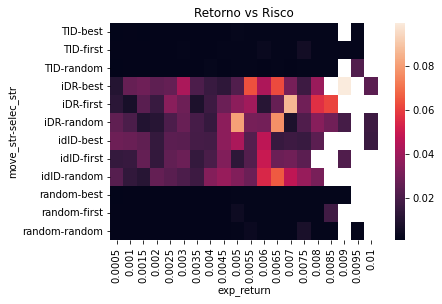

In [ ]:
best_data_pivot = best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

sns.heatmap(best_data_pivot)
plt.title('Retorno vs Risco')